In [7]:
import torch
import numpy as np
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# LinUCB Algorithm

class LinUCB:
    """
    LinUCB algorithm for contextual bandits.
    Each arm is modeled with a linear model and an upper confidence bound.
    """
    def __init__(self, n_arms, d, beta=1.0):
        """
        Args:
            n_arms (int): Number of arms (actions).
            d (int): Dimension of feature space.
            beta (float): Exploration parameter (higher = more exploration).
        """
        self.n_arms = n_arms
        self.d = d
        self.beta = beta
        # Maintain empirical covariance matrix (d x d) and b (d x 1) = \sum_i r_i Phi_i
        self.Cov = torch.zeros((d, d), device=device, dtype=torch.float32)
        self.b = torch.zeros(d, device=device, dtype=torch.float32)
        # Technically don't need r and Phi below, just need to keep track of r and covariance matrix.
        self.r = []
        self.Phi = []

    def select_arm(self, contexts):
        """
        Selects the arm to play given the contexts for each arm.
        Args:
            contexts (torch.Tensor): Shape (n_arms, n_features). Each row is the context for an arm.
        Returns:
            int: Index of the selected arm.
        """
        # Convert contexts to float32 if needed
        contexts = contexts.to(dtype=torch.float32)

        p = torch.zeros(self.n_arms, device=device)
        # TODO: compute the least squares solution as below
        C_inv = torch.linalg.pinv(self.Cov) # should be careful here if C is low-rank
        theta_hat = C_inv @ self.b # Unregularized least squares solution

        C_reg_inv = torch.linalg.pinv(self.Cov + torch.eye(self.d, device=device, dtype=torch.float32))
        for a in range(self.n_arms):
            phi_a = contexts[a]
            # TODO: Compute the line below.
            p[a] = (theta_hat.T @ phi_a) + self.beta * torch.sqrt(phi_a.T @ C_reg_inv @ phi_a)
        return int(torch.argmax(p))

    def update(self, arm, context, reward):
        """
        Updates the model for the chosen arm.
        Args:
            arm (int): Index of the chosen arm.
            context (torch.Tensor): Feature vector (n_features,).
            reward (float): Observed reward.
        """
        # Convert context to float32 if needed
        phi_a = context.to(dtype=torch.float32)

        # self.A[arm] += phi_a @ phi_a.T
        self.Cov += torch.outer(phi_a, phi_a)
        # self.b[arm] += reward * phi_a
        self.b += reward * phi_a
        self.r.append(reward)
        self.Phi.append(phi_a)

/tmp/ipython-input-2-282422475.py:45: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  p[a] = (theta_hat.T @ phi_a) + self.beta * torch.sqrt(phi_a.T @ C_reg_inv @ phi_a)


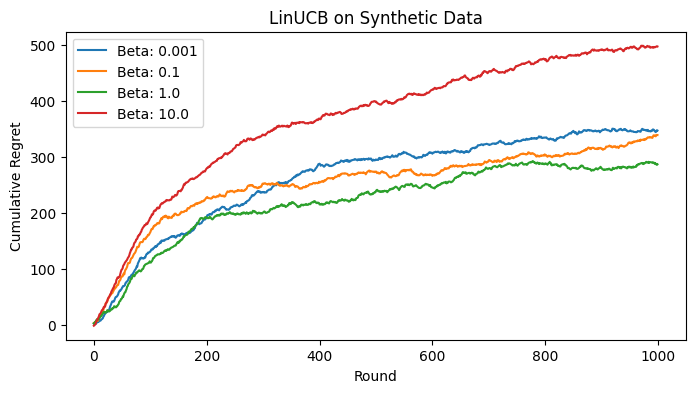

In [3]:
# Synthetic experiment for LinUCB
# Parameters
n_arms = 100
n_x = 50  # dimension of random part
n_emb = 20  # dimension of arm embedding
n_features = n_x + n_emb
n_rounds = 1000
torch.manual_seed(42)


def get_perm_embeddings(context, actions):
    contexts = torch.zeros((n_arms, n_features), device=device)
    for a in actions:
        vector = torch.cat([x, arm_embeddings[a]])
        vector = torch.roll(vector, a)
        contexts[a] = vector
    return contexts

def get_random_context(n_x):
    return lambda: torch.randn(n_x, device=device)

# Fixed arm embeddings
arm_embeddings = torch.randn(n_arms, n_emb, device=device)

# Hidden linear model (unknown to LinUCB)
true_theta = torch.randn(n_features, 1, device=device) / torch.sqrt(torch.tensor(n_features, dtype=torch.float32, device=device))

plt.figure(figsize=(8, 4))

emb_fun = get_perm_embeddings
data_fun = get_random_context(n_x)

for beta in [0.001, 0.1, 1.0, 10.0]:
    # LinUCB instance
    linucb = LinUCB(n_arms=n_arms, d=n_features, beta=beta)

    rewards = []
    cum_rewards = []

    best_rewards = []
    cum_best = []

    for t in range(n_rounds):
        # Generate random context x
        x = data_fun()
        contexts = emb_fun(x, range(n_arms))
        # LinUCB selects arm
        chosen_arm = linucb.select_arm(contexts)
        # Get best arm's reward
        best_arm_reward = torch.max(contexts @ true_theta)
        # Simulate reward: dot(true_theta, context) + noise
        reward = true_theta.T @ contexts[chosen_arm] + 1 * torch.randn(1, device=device)
        # Update LinUCB
        linucb.update(chosen_arm, contexts[chosen_arm], reward.item())
        rewards.append(reward.item())
        best_rewards.append(best_arm_reward.item())
        cum_rewards.append(np.sum(rewards))
        cum_best.append(np.sum(best_rewards))

    # Plot cumulative reward
    # plt.plot(cum_rewards)
    # plt.plot(cum_best)
    plt.plot(np.array(cum_best) - np.array(cum_rewards), label="Beta: %s" % beta)
plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('LinUCB on Synthetic Data')
plt.legend()
plt.show()

In [36]:
# Inverse Gap Weighting

def project_onto_l2_ball(w, R):
    norm = torch.linalg.norm(w)
    return w if norm <= R else R * w / norm

# TODO: Implement Online Gradient Descent update to theta
def OGD(eta, theta, x, y):
    y_hat = torch.dot(theta, x)
    gradient = 2 * x * (y_hat - y)
    theta = theta - eta * gradient
    theta = project_onto_l2_ball(theta, 2)
    loss = (y_hat - y) ** 2
    return theta, loss

class InverseGapWeighting:
    """
    Implements the inverse gap weighting strategy for linear bandits.
    At each round, estimates the expected reward for each arm, computes the gap between the best and other arms,
    and samples arms with probability proportional to the inverse of these gaps (plus a "normalizing" lambda in the denominator).
    """
    def __init__(self, n_arms, d, gamma=1.0, estimator="OGD", eta=0.1):
        """
        Args:
            n_arms (int): Number of arms (actions).
            d (int): Dimension of feature space.
            gamma (float): Controls amount of exploration (higher gamma = LESS exploration)
        """
        self.n_arms = n_arms
        self.d = d
        self.Cov = torch.zeros((d, d), device=device, dtype=torch.float32)
        self.b = torch.zeros(d, device=device, dtype=torch.float32)
        self.gamma = gamma
        self.estimator = estimator # OGD: online grad descent, LS: least squares, FTRL
        self.theta = torch.zeros(d, device=device, dtype=torch.float32)
        self.eta = eta

    def select_arm(self, contexts):
        """
        Selects an arm to play using inverse gap weighting.
        Args:
            contexts (torch.Tensor): Shape (n_arms, d). Each row is the context for an arm.
        Returns:
            int: Index of the selected arm.
        """
        # Convert contexts to float32 if needed
        contexts = contexts.to(dtype=torch.float32)

        # TODO: Estimate theta (unnecessary this is already done in "update")

        # TODO: Compute expected rewards
        est_rewards = contexts @ self.theta
        # TODO: compute the gap between the best and other arms
        best_reward = torch.max(est_rewards)
        gaps = best_reward - est_rewards
        weights = self.weights_from_gaps(gaps, self.gamma)
        chosen_arm = torch.multinomial(weights, 1).item()
        return int(chosen_arm)

    # TODO: Implement a function that computes the weights on each arm given the gaps.
    def weights_from_gaps(self, gaps, gamma):
        gaps_np = gaps.cpu().numpy()
        sorted_gaps = np.sort(gaps_np)
        A = len(sorted_gaps)
        sum_inv_weights = 0.0
        for i in range(A)[::-1]:
            sum_inv_weights += 1.0 / (sorted_gaps[i] ** gamma + 0.0001)
            if sum_inv_weights > 1.0:
                lamb = 1/(i + 1)
                break
        weights = 1.0 / (lamb + gaps_np ** gamma)
        weights /= np.sum(weights)
        return torch.tensor(weights, device=device, dtype=torch.float32)


    def update(self, arm, context, reward):
        """
        Updates the model for the chosen arm.
        Args:
            arm (int): Index of the chosen arm.
            context (torch.Tensor): Feature vector (d,).
            reward (float): Observed reward.
        """
        # Convert context to float32 if needed
        phi_a = context.to(dtype=torch.float32)

        self.Cov += torch.outer(phi_a, phi_a)
        self.b += reward * phi_a
        if self.estimator == "OGD":
            self.theta, loss = OGD(self.eta, self.theta, phi_a, reward)
        if self.estimator == "FTRL":
            y_hat = torch.dot(self.theta, phi_a)
            loss = (y_hat - reward) ** 2 # This will be large because includes noise
            self.theta = torch.linalg.pinv(self.Cov + 3*torch.eye(self.d, device=device, dtype=torch.float32)) @ self.b
            self.theta = project_onto_l2_ball(self.theta, 2)
        if self.estimator == "LS":
            y_hat = torch.dot(self.theta, phi_a)
            loss = (y_hat - reward) ** 2 # This will be large because includes noise
            self.theta = torch.linalg.pinv(self.Cov) @ self.b
            self.theta = project_onto_l2_ball(self.theta, 2)
        return loss.item()

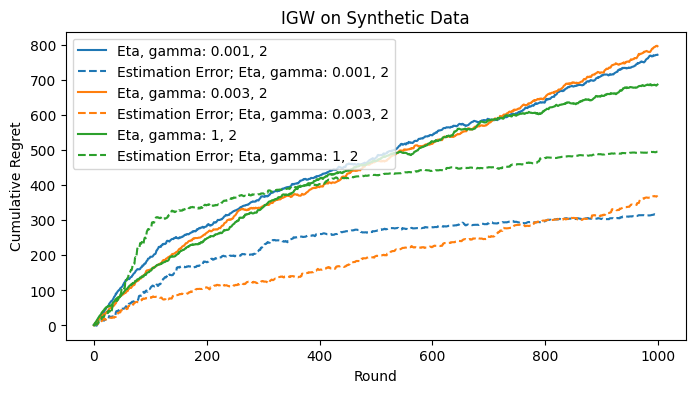

In [5]:
# Synthetic experiment for IGW
# Parameters
n_arms = 100
n_x = 50  # dimension of random part
n_emb = 20  # dimension of arm embedding
n_features = n_x + n_emb
n_rounds = 1000
# torch.manual_seed(42)

# Fixed arm embeddings
arm_embeddings = torch.randn(n_arms, n_emb, device=device)

# Hidden linear model (unknown to LinUCB)
true_theta = torch.randn(n_features, 1, device=device) / torch.sqrt(torch.tensor(n_features, dtype=torch.float32, device=device))

plt.figure(figsize=(8, 4))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
i = 0

for eta in [0.001, 0.003, 1]:
    for gamma in [2]:#[1, 2, 4, 8]:
        # IGW instance
        igw = InverseGapWeighting(n_arms=n_arms, d=n_features, eta=eta, gamma=gamma)
        if eta > 0.5:
            igw = InverseGapWeighting(n_arms=n_arms, d=n_features, estimator="LS", gamma=gamma)

        rewards = []
        cum_rewards = []

        best_rewards = []
        cum_best = []
        losses = []
        cum_loss = []

        best_losses = []
        cum_best_loss = []

        for t in range(n_rounds):
            x = data_fun()
            contexts = emb_fun(x, range(n_arms))
            # IGW selects arm
            chosen_arm = igw.select_arm(contexts)
            # Get best arm's reward
            best_arm_reward = torch.max(contexts @ true_theta)
            # Simulate reward: dot(true_theta, context) + noise
            reward = true_theta.T @ contexts[chosen_arm] + 1 * torch.randn(1, device=device)
            # Update IGW
            loss = igw.update(chosen_arm, contexts[chosen_arm], reward.item())
            losses.append(loss)
            cum_loss.append(np.sum(losses))
            best_loss = (true_theta.T @ contexts[chosen_arm] - reward)**2
            best_losses.append(best_loss.item())
            cum_best_loss.append(np.sum(best_losses))

            rewards.append(reward.item())
            best_rewards.append(best_arm_reward.item())
            cum_rewards.append(np.sum(rewards))
            cum_best.append(np.sum(best_rewards))

        # Plot cumulative reward
        # plt.plot(cum_rewards)
        # plt.plot(cum_best)
        plt.plot(np.array(cum_best) - np.array(cum_rewards), color=colors[i], label="Eta, gamma: %s, %s" % (eta, gamma))
        plt.plot(np.array(cum_loss) - np.array(cum_best_loss), linestyle='dashed', color=colors[i], label="Estimation Error; Eta, gamma: %s, %s" % (eta, gamma))
        i += 1
plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('IGW on Synthetic Data')
plt.legend()
plt.show()

In [6]:
# Linear Contextual Bandits with LLM data
import importlib
import torch
from transformers import AutoTokenizer, LlamaTokenizer, AutoModelForCausalLM, pipeline
import transformers
from datasets import load_dataset, Dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [26]:
# del model
# del base_model
# Load the base llama model
model_path = "Qwen/Qwen1.5-0.5B-Chat"
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = model.to(device)
model.eval()

# # Check that it can generate text
# pipe = pipeline(
#     "text-generation",
#     model=model_path,
#     torch_dtype=torch.bfloat16,
#     device_map="auto"
# )
# print(pipe("The best episode of Seinfeld is when"))

# del pipe # clear memory

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (up_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (down_proj): Linear(in_features=2816, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1024,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((1024,), eps=1e-06)
    (rotary_emb): 

In [9]:
print(model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (up_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (down_proj): Linear(in_features=2816, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1024,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((1024,), eps=1e-06)
    (rotary_emb): 

In [10]:
data = [
  {
    "patient": "A 58-year-old man with a long history of smoking presents with chronic cough, wheezing, and shortness of breath.",
    "treatment": "Inhaled corticosteroids (e.g., fluticasone)"
  },
  {
    "patient": "A 34-year-old woman experiences frequent panic attacks and describes persistent anxiety and restlessness.",
    "treatment": "Sertraline"
  },
  {
    "patient": "A 70-year-old woman reports worsening memory, confusion, and difficulty with daily tasks over the past year.",
    "treatment": "Donepezil"
  },
  {
    "patient": "A 22-year-old college student presents with fever, sore throat, and tender cervical lymph nodes.",
    "treatment": "Supportive care for infectious mononucleosis"
  },
  {
    "patient": "A 45-year-old man with obesity and fatigue is diagnosed with type 2 diabetes after routine labs.",
    "treatment": "Metformin"
  },
  {
    "patient": "A 29-year-old woman complains of pelvic pain, painful periods, and infertility.",
    "treatment": "Laparoscopic surgery for endometriosis"
  },
  {
    "patient": "A 67-year-old man with a history of hypertension presents with chest pain radiating to the left arm.",
    "treatment": "Aspirin and cardiac catheterization"
  },
  {
    "patient": "A 50-year-old woman presents with fatigue, dry skin, weight gain, and cold intolerance.",
    "treatment": "Levothyroxine"
  },
  {
    "patient": "A 10-year-old boy has recurrent wheezing and nighttime coughing episodes triggered by exercise.",
    "treatment": "Albuterol inhaler"
  },
  {
    "patient": "A 72-year-old man reports difficulty initiating urination and a weak urine stream.",
    "treatment": "Tamsulosin"
  },
  {
    "patient": "A 31-year-old woman with recent travel history presents with high fever, chills, and jaundice.",
    "treatment": "Artemisinin-based combination therapy (for malaria)"
  },
  {
    "patient": "A 26-year-old man with seasonal allergies complains of sneezing, nasal congestion, and itchy eyes.",
    "treatment": "Loratadine"
  },
  {
    "patient": "A 40-year-old man with a sedentary lifestyle experiences left calf swelling, pain, and warmth.",
    "treatment": "Enoxaparin"
  },
  {
    "patient": "A 62-year-old woman presents with bone pain, a recent vertebral fracture, and low bone mineral density.",
    "treatment": "Alendronate"
  },
  {
    "patient": "A 48-year-old woman with a family history of breast cancer has a newly discovered 2 cm breast lump.",
    "treatment": "Core needle biopsy"
  },
  {
    "patient": "A 5-year-old girl develops a barking cough, stridor, and hoarseness, mostly at night.",
    "treatment": "Dexamethasone"
  },
  {
    "patient": "A 55-year-old man with chronic alcohol use presents with tremors, confusion, and ataxia.",
    "treatment": "Thiamine supplementation"
  },
  {
    "patient": "A 60-year-old woman presents with pain and stiffness in the shoulders and hips, especially in the morning.",
    "treatment": "Low-dose prednisone"
  },
  {
    "patient": "A 37-year-old man reports burning epigastric pain relieved by eating and worsened at night.",
    "treatment": "Omeprazole"
  },
  {
    "patient": "A 25-year-old woman presents with fatigue, pallor, and heavy menstrual bleeding.",
    "treatment": "Ferrous sulfate"
  }
]



In [11]:
treatments = [
  "Respiratory treatments",
  "Neurological & psychiatric treatments",
  "Cardiovascular & hematologic treatments",
  "Endocrine & metabolic treatments",
  "Infectious disease treatments",
  "Women’s health & reproductive treatments",
  "Gastrointestinal & nutritional treatments",
]

In [29]:
# Build a get_LLM_embeddings function
# Normalize the contexts to have norm \sqrt{n_features} to match the other experiments
import math

target_module = model.model.norm # This is the final layer before moving into the vocabulary space
print(target_module)
for module in model.modules():
    module._forward_hooks.clear()

# get_embedding takes two pieces of text as input: the patient description (text), and the treatment (text)
# It returns the final layer embeddings produced by the model for each treatement.
def get_LLM_embeddings(context, treatments):
    all_contexts = []

    def context_hook(module, input, output):
        all_contexts.append(output[0][-1])

    hook = target_module.register_forward_hook(context_hook)
    for treatment in treatments:
        full_prompt = f'Patient: {context}. Treatment: {treatment}. Is this treatment good (give a yes or no answer).'
        tokenized_input = tokenizer(full_prompt, return_tensors="pt")
        tokenized_input = tokenized_input.to(device)
        with torch.no_grad():
            output = model(**tokenized_input)
    hook.remove()

    # Convert to tensor at the end if needed
    all_contexts_tensor = torch.stack(all_contexts).to(dtype=torch.float32)  # Shape: (num_treatments, 2048)
    all_contexts_tensor = math.sqrt(all_contexts_tensor.shape[1])*all_contexts_tensor / torch.norm(all_contexts_tensor, dim=1, keepdim=True)
    return all_contexts_tensor

all_contexts = get_LLM_embeddings("A 25-year-old woman presents with fatigue, pallor, and heavy menstrual bleeding.", treatments)
print(all_contexts.shape)
print(torch.norm(all_contexts, dim=1))

Qwen2RMSNorm((1024,), eps=1e-06)
torch.Size([7, 1024])
tensor([32.0000, 32.0000, 32.0000, 32.0000, 32.0000, 32.0000, 32.0000],
       device='cuda:0')


In [25]:
# Extract true_theta from Model
# Normalize it to have norm 1 to match the other experiments

yes_token_id = tokenizer.encode("yes", add_special_tokens=False)[0]
no_token_id = tokenizer.encode("no", add_special_tokens=False)[0]
print(f"Token ID for 'yes': {yes_token_id}")
print(f"Token ID for 'no': {no_token_id}")
yes_embedding = model.lm_head.weight[yes_token_id]
no_embedding = model.lm_head.weight[no_token_id]

true_theta = (yes_embedding - no_embedding).to(dtype=torch.float32)
true_theta = true_theta/torch.norm(true_theta)
print(true_theta)
print(len(true_theta))
print(torch.norm(true_theta))

Token ID for 'yes': 9693
Token ID for 'no': 2152
tensor([-0.0253,  0.0066,  0.0117,  ..., -0.0466, -0.0646,  0.0371],
       device='cuda:0', grad_fn=<DivBackward0>)
1024
tensor(1., device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


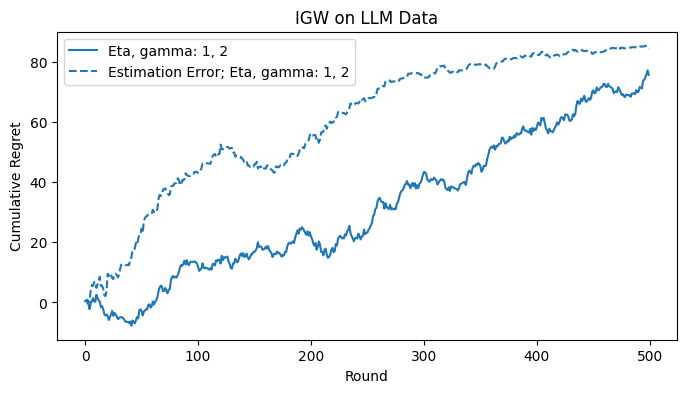

In [40]:
# LLM experiment for IGW
# Parameters
n_arms = 7
n_features = 1024
n_rounds = 500
# torch.manual_seed(42)

def data_fun():
    return data[np.random.randint(0, len(data))]["patient"]

# Define algorithm configurations
configs = []
for eta in [1]:
    for gamma in [2]:#[1, 2, 4, 8]:
        configs.append({'eta': eta, 'gamma': gamma})

# Initialize IGW instances for each configuration
igw_instances = []
for config in configs:
    eta, gamma = config['eta'], config['gamma']
    if eta > 0.5:
        igw = InverseGapWeighting(n_arms=n_arms, d=n_features, estimator="FTRL", gamma=gamma)
    else:
        igw = InverseGapWeighting(n_arms=n_arms, d=n_features, eta=eta, gamma=gamma)
    igw_instances.append(igw)

# Initialize tracking arrays for each algorithm
n_configs = len(configs)
rewards = [[] for _ in range(n_configs)]
cum_rewards = [[] for _ in range(n_configs)]
best_rewards = [[] for _ in range(n_configs)]
cum_best = [[] for _ in range(n_configs)]
losses = [[] for _ in range(n_configs)]
cum_loss = [[] for _ in range(n_configs)]
best_losses = [[] for _ in range(n_configs)]
cum_best_loss = [[] for _ in range(n_configs)]

# Main loop: outer loop over time, inner loop over algorithms
for t in range(n_rounds):
    # Generate context once per round
    x = data_fun()
    contexts = get_LLM_embeddings(x, treatments)

    # Get best arm's reward (same for all algorithms)
    best_arm_reward = torch.max(contexts @ true_theta)

    # Inner loop: run all algorithms on the same contexts
    for i, (igw, config) in enumerate(zip(igw_instances, configs)):
        # IGW selects arm
        chosen_arm = igw.select_arm(contexts)

        # Simulate reward: dot(true_theta, context) + noise
        reward = true_theta.T @ contexts[chosen_arm] + 1 * torch.randn(1, device=device)

        # Update IGW
        loss = igw.update(chosen_arm, contexts[chosen_arm], reward.item())

        # Track metrics for this algorithm
        losses[i].append(loss)
        cum_loss[i].append(np.sum(losses[i]))

        best_loss = (true_theta.T @ contexts[chosen_arm] - reward)**2
        best_losses[i].append(best_loss.item())
        cum_best_loss[i].append(np.sum(best_losses[i]))

        rewards[i].append(reward.item())
        best_rewards[i].append(best_arm_reward.item())
        cum_rewards[i].append(np.sum(rewards[i]))
        cum_best[i].append(np.sum(best_rewards[i]))

# Set up plotting
plt.figure(figsize=(8, 4))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Plot results for each algorithm
for i, config in enumerate(configs):
    eta, gamma = config['eta'], config['gamma']
    plt.plot(np.array(cum_best[i]) - np.array(cum_rewards[i]),
             color=colors[i], label="Eta, gamma: %s, %s" % (eta, gamma))
    plt.plot(np.array(cum_loss[i]) - np.array(cum_best_loss[i]),
             linestyle='dashed', color=colors[i],
             label="Estimation Error; Eta, gamma: %s, %s" % (eta, gamma))

plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('IGW on LLM Data')
plt.legend()
plt.show()